In [1]:
import io
import subprocess
import os

from tensorflow.compat.v1.keras import layers
import tensorflow.compat.v1 as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from tf_graph_util import convert_variables_to_constants
from lstm import create_lstm

from seq2seq import create_seq2seq

In [2]:
RANDOM_SEED = 42

In [3]:
import os
def benchmark_model(model, cmd=None):
    bench_path = f"{model.name}_benchmark.txt"
    if not os.path.exists(f"{model.name}.pbtxt") and not os.path.exists(bench_path):
        if not os.path.exists(f"{model.name}.pbtxt"):
            print("Saving model...")
            tf.keras.backend.clear_session()
            sess = tf.keras.backend.get_session()
    #         output_graph_def = tf.graph_util.convert_variables_to_constants(
            output_graph_def = convert_variables_to_constants(
                sess,
                sess.graph.as_graph_def(),
                [node.op.name for node in model.outputs])
            tf.io.write_graph(output_graph_def, './', f'{model.name}.pbtxt')
        else:
            print("Retrieving saved model.")
    
    
        if not os.path.exists(bench_path):
            if not cmd:
                input_shape = f"1,{','.join(str(dim) for dim in model.input.shape[1:])}"
                cmd = f'../tensorflow/bazel-bin/tensorflow/tools/benchmark/benchmark_model --graph={model.name}.pbtxt --input_layer="{model.input.name}" --input_layer_shape="{input_shape}" --output_layer="{model.output.name}"'
                print(cmd)
            print("Running benchmark...")
            benchmark = subprocess.run([cmd], stderr=subprocess.PIPE, shell=True)
            print("Done.")

            output = benchmark.stderr.decode('unicode_escape')
            split_output = output[output.find('Run Order'):output.find('Top by Computation Time')].split('\n')

            with open(bench_path, 'w') as f:
                f.write("\n".join(split_output[1:-2]))
        else:
            print("Retrieving saved benchmark results.")
    else:
        print("Retrieving saved model and benchmark results.")
    
    f = open(bench_path)
    benchmark = pd.read_csv(f, sep="\t").rename(columns=lambda x: x.strip())
    benchmark = benchmark.drop(benchmark.columns[0], axis=1)
    benchmark['name'] = benchmark['[Name]'].apply(lambda x: x.split('/')[0])
    return benchmark

In [4]:
def get_layer_features(model):
    layers = pd.DataFrame()
    layers['name'] = pd.Series([layer.name for layer in model.layers])
    
#     input_dims = {layer.name: [dim.value for dim in layer.input.shape.dims] for layer in model.layers}
    
#     layers['input_shape'] = pd.Series([[dim.value for dim in layer.input.shape.dims] for layer in model.layers])
#     layers['output_shape'] = pd.Series([[dim.value for dim in layer.output.shape.dims] for layer in model.layers])
    layers['input_shape'] = pd.Series([layer.input_shape for layer in model.layers])
    layers['output_shape'] = pd.Series([layer.output_shape for layer in model.layers])

    features = ['units','filters','activation','strides','kernel_size']
    for feature in features:
        layers[feature] = pd.Series(
            [layer.get_config()[feature] if feature in layer.get_config() else None for layer in model.layers])
    return layers

In [5]:
def join_benchmark(features, benchmark):
    speed = benchmark[['name', '[avg ms]']].groupby('name').sum()
    mem = benchmark[['name', '[mem KB]']].groupby('name').max()
    
    return features.join(speed, on='name').join(mem, on='name')

In [81]:

def flatten_shape(shape):
    if not shape:
        return None
    
    def reduce(tup):
        acc = 1
        for val in tup:
            if val:
                acc *= val
        return acc
    
    if isinstance(shape, list):
        return sum(reduce(tup) for tup in shape)
    
    return reduce(shape)


def clean(data, inference=False):
    if inference:
        cleaned = pd.get_dummies(data, columns=['activation'], dummy_na=True)
    else:
        cleaned = pd.get_dummies(
            data.dropna(subset=['[avg ms]', '[mem KB]']), columns=['activation'], dummy_na=True)
    
    for activation in ['selu', 'elu', 'softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'exponential', 'linear']:
        col = f"activation_{activation}"
        if col not in cleaned.columns:
            cleaned[col] = pd.Series(0)
    

    cleaned['input_size'] = cleaned['input_shape'].apply(flatten_shape)
    cleaned['output_size'] = cleaned['output_shape'].apply(flatten_shape)
    cleaned['stride_size'] = cleaned['strides'].apply(flatten_shape)
    cleaned['kernel_size'] = cleaned['kernel_size'].apply(flatten_shape)

    return cleaned.fillna(-1)



In [82]:
def rf_regression_model(data, column):
    X = data.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    y = data[column]  # Labels

    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state = RANDOM_SEED) # 70% training and 30% test

    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = RANDOM_SEED)
    # Train the model on training data
    rf.fit(X_train, y_train);

    return rf, X_test, y_test

In [83]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

def stacked_regression_model(data, column):

    X = data.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    y = data[column]  # Labels

    estimators = [
        ('rf', RandomForestRegressor(n_estimators=1000, random_state=RANDOM_SEED)),
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42)),
        
    ]
    reg = StackingRegressor(
        estimators=estimators,
#         final_estimator=RandomForestRegressor(n_estimators=1000, random_state=RANDOM_SEED)
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    reg.fit(X_train, y_train).score(X_test, y_test)
    
    return reg, X_test, y_test

In [84]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

def stacked_regression_model_2(data, column):

    X = data.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    y = data[column]  # Labels
    
    poly = Pipeline([
        ('poly', PolynomialFeatures(degree=5)),
        ('linear', LinearRegression(fit_intercept=False))
    ])

    estimators = [
        ('poly', poly),
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42)),
        
    ]
    reg = StackingRegressor(
        estimators=estimators,
#         final_estimator=RandomForestRegressor(n_estimators=1000, random_state=RANDOM_SEED)
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    reg.fit(X_train, y_train).score(X_test, y_test)
    
    return reg, X_test, y_test

In [85]:
tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.
model = tf.keras.applications.vgg16.VGG16(
    include_top=True,
    weights='imagenet')

In [86]:
benchmark = benchmark_model(model)
features = get_layer_features(model)

Retrieving saved model and benchmark results.


In [87]:
vgg_df = join_benchmark(features, benchmark)

In [88]:
tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.
tf.keras.backend.set_learning_phase(0)
inception = tf. keras.applications.inception_v3.InceptionV3(
    include_top=True, weights='imagenet')
inception_benchmark = benchmark_model(inception)
inception_features = get_layer_features(inception)
inception_df = join_benchmark(inception_features, inception_benchmark)

Retrieving saved model and benchmark results.


In [89]:
# # lstm.summary()

# tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.

# lstm = create_lstm()

# # tf.keras.backend.set_learning_phase(0)
# lstm_benchmark = benchmark_model(lstm)
# lstm_features = get_layer_features(lstm)
# lstm_df = join_benchmark(lstm_features, lstm_benchmark)

In [90]:
data = pd.concat([vgg_df, inception_df])
data.sample(10)

,name,input_shape,output_shape,units,filters,activation,strides,kernel_size,[avg ms],[mem KB]
243,batch_normalization_71,"(None, 8, 8, 320)","(None, 8, 8, 320)",NaN,NaN,None,None,None,0.006,0.000
191,batch_normalization_59,"(None, 17, 17, 192)","(None, 17, 17, 192)",NaN,NaN,None,None,None,0.005,0.000
9,activation_2,"(None, 147, 147, 64)","(None, 147, 147, 64)",NaN,NaN,relu,None,None,4.014,5531.904
112,activation_36,"(None, 17, 17, 128)","(None, 17, 17, 128)",NaN,NaN,relu,None,None,0.671,147.968
33,batch_normalization_7,"(None, 35, 35, 64)","(None, 35, 35, 64)",NaN,NaN,None,None,None,0.004,0.000
234,activation_73,"(None, 17, 17, 192)","(None, 17, 17, 192)",NaN,NaN,relu,None,None,0.851,221.952
21,conv2d_6,"(None, 35, 35, 192)","(None, 35, 35, 48)",NaN,48.0,linear,"(1, 1)","(1, 1)",0.002,0.000
31,conv2d_11,"(None, 35, 35, 192)","(None, 35, 35, 32)",NaN,32.0,linear,"(1, 1)","(1, 1)",0.002,0.000
283,conv2d_86,"(None, 8, 8, 2048)","(None, 8, 8, 384)",NaN,384.0,linear,"(1, 1)","(1, 1)",0.002,0.000
139,conv2d_41,"(None, 17, 17, 768)","(None, 17, 17, 160)",NaN,160.0,linear,"(1, 1)","(1, 1)",0.002,0.000


In [91]:
cleaned = clean(data)

cleaned.head()

,name,input_shape,output_shape,units,filters,strides,kernel_size,[avg ms],[mem KB],activation_linear,...,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size
1,block1_conv1,"(None, 224, 224, 3)","(None, 224, 224, 64)",-1.0,64.0,"(1, 1)",9.0,2.657,12845.056,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,150528,3211264,1.0
2,block1_conv2,"(None, 224, 224, 64)","(None, 224, 224, 64)",-1.0,64.0,"(1, 1)",9.0,18.123,12845.056,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3211264,3211264,1.0
3,block1_pool,"(None, 224, 224, 64)","(None, 112, 112, 64)",-1.0,-1.0,"(2, 2)",-1.0,3.437,3211.264,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,3211264,802816,4.0
4,block2_conv1,"(None, 112, 112, 64)","(None, 112, 112, 128)",-1.0,128.0,"(1, 1)",9.0,7.181,6422.528,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,802816,1605632,1.0
5,block2_conv2,"(None, 112, 112, 128)","(None, 112, 112, 128)",-1.0,128.0,"(1, 1)",9.0,13.004,6422.528,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1605632,1605632,1.0


In [92]:

X = cleaned.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
y = cleaned['[avg ms]']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1).sample(20)

MSE: 0.7300811553189278


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
281,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,28672,28672,-1.0,0.004,0.007771
202,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,1.154,0.853289
275,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,20480,20480,-1.0,1.050,1.142880
268,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,81920,12288,1.0,0.002,0.002463
25,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,58800,58800,-1.0,0.450,0.598330
18,-1.0,64.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,235200,78400,1.0,0.002,0.002029
122,-1.0,192.0,7.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,36992,55488,1.0,0.002,0.002223
6,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1605632,401408,4.0,1.788,5.010697
123,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.002,0.002268
51,-1.0,64.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,313600,78400,1.0,0.002,0.003717


In [93]:

X = cleaned.drop(['name', '[avg ms]', '[mem KB]', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
y = cleaned['[mem KB]']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train);

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'mem_KB_actual': y_test, 'mem_KB_pred': y_pred})], axis=1).sample(20)

MSE: 1480980.8144832274


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,mem_KB_actual,mem_KB_pred
143,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,46240,-1.0,184.960,184.931840
188,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.000,0.000000
264,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,0.000,0.000000
305,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12288,12288,-1.0,0.000,0.032768
19,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,25088,25088,-1.0,0.016,0.000000
213,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,221.952,221.952000
179,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,46240,-1.0,0.000,0.000000
125,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.000,0.000000
165,-1.0,160.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,46240,1.0,0.000,0.000000
37,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,313.600,313.521600


In [94]:
# AVG MS RF
cnn_ms_rf, X_test, y_test = rf_regression_model(cleaned, '[avg ms]')

y_pred = cnn_ms_rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

cnn_ms_rf_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1).sample(10)

MSE: 0.3499471311167615


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
156,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.006,0.005430
198,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.007,0.005430
189,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.007,0.005430
105,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,36992,36992,-1.0,0.003,0.004729
1,-1.0,32.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,268203,710432,4.0,0.002,0.512949
54,-1.0,64.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,313600,78400,1.0,0.002,0.002025
80,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,117600,117600,-1.0,0.004,0.014585
202,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,1.154,0.902445
295,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,0.007,0.005137
55,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.005,0.004020


In [95]:
# MEM KB RF
cnn_mem_rf, X_test, y_test = rf_regression_model(cleaned, '[mem KB]')

y_pred = cnn_mem_rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_mem_rf_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1).sample(10)

MSE: 70984.64512575942


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
295,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,0.000,0.000000
103,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,36992,36992,-1.0,147.968,147.535616
278,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,12288,12288,-1.0,49.152,50.151424
147,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,46240,-1.0,0.000,0.000000
288,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,98.304,98.304000
296,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,0.000,0.000000
229,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.000,0.000000
98,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,27744,27744,-1.0,110.976,108.396544
69,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,58800,58800,-1.0,0.000,0.000000
89,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,313.600,313.600000


In [96]:
# AVG MS stacked
cnn_ms_stacked_1, X_test, y_test = stacked_regression_model(cleaned, '[avg ms]')

y_pred = cnn_ms_stacked_1.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_ms_stacked_1_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1).sample(10)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

MSE: 2.4571264901270733


,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
275,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,20480,20480,-1.0,1.050,1.091647
180,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,46240,-1.0,0.006,-0.222139
229,-1.0,192.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,221952,55488,1.0,0.002,0.367585
81,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.003,-0.019767
158,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.006,-0.164007
191,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.005,-0.164007
53,-1.0,96.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,117600,117600,1.0,0.002,0.173694
40,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,313600,313600,-1.0,0.384,1.310546
236,-1.0,192.0,7.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,1.0,0.003,0.668197
261,-1.0,384.0,3.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,1.0,0.002,2.238347


In [97]:
# AVG MEM stacked
cnn_mem_stacked_1, X_test, y_test = stacked_regression_model(cleaned, '[mem KB]')

y_pred = cnn_mem_stacked_1.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_mem_stacked_1_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1).sample(10)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 555240.4477081143


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
129,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,221.952,249.100040
137,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,46240,-1.0,0.000,-87.383302
208,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,221.952,249.100040
205,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.000,-48.972566
186,-1.0,192.0,7.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,55488,1.0,0.000,-154.045969
159,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.000,-48.972566
302,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,24576,24576,-1.0,98.304,128.361360
241,-1.0,320.0,9.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,20480,4.0,0.000,-30.102100
63,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,352800,352800,-1.0,1411.200,1105.380382
249,-1.0,448.0,1.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,81920,28672,1.0,0.000,118.071912


In [98]:
#lstm stacked avg ms
cnn_ms_stacked_2, X_test, y_test = stacked_regression_model_2(cleaned, '[avg ms]')

y_pred = cnn_ms_stacked_2.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_ms_stacked_2_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1).head()

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 3.4732015849117315


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
222,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,0.006,0.357337
85,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.778,0.847737
166,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,46240,-1.0,0.006,0.345422
36,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.464,0.847737
19,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.003,0.386857


In [99]:
#lstm stacked mem
cnn_mem_stacked_2, X_test, y_test = stacked_regression_model_2(cleaned, '[mem KB]')

y_pred = cnn_mem_stacked_2.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
cnn_mem_stacked_2_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1).head()

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 4468742733189014.5


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_linear,activation_relu,activation_softmax,activation_nan,activation_selu,activation_elu,activation_softplus,activation_softsign,activation_tanh,activation_sigmoid,activation_hard_sigmoid,activation_exponential,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
225,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,221.952,-6.692743e+07
32,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,78400,78400,-1.0,0.000,-6.692776e+07
9,-1.0,256.0,9.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,802816,802816,1.0,3211.264,-6.692269e+07
234,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,55488,55488,-1.0,221.952,-6.692743e+07
182,-1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,46240,46240,-1.0,184.960,-6.692747e+07


In [100]:
# lstm.summary()

tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.

lstm = create_lstm()

# tf.keras.backend.set_learning_phase(0)
lstm_benchmark = benchmark_model(lstm)
lstm_benchmark.sample(15)

Retrieving saved model and benchmark results.


,[node type],[start],[first],[avg ms],[%],[cdf%],[mem KB],[times called],[Name],name
131,Add,140.384,0.004,0.003,0.333%,30.046%,0.004,250,lstm4/while/add_9,lstm4
68,Switch,190.693,0.003,0.002,0.210%,16.796%,0.000,251,lstm5/while/Switch,lstm5
206,Add,95.325,0.008,0.003,0.296%,45.060%,0.000,250,lstm3/while/add_5,lstm3
516,Minimum,-0.891,0.002,0.002,0.199%,96.554%,0.000,250,lstm1/while/clip_by_value_2/Minimum,lstm1
334,Pack,23.152,0.012,0.010,0.004%,73.083%,0.008,1,lstm2/zeros_1/packed,lstm2
280,Maximum,46.129,0.004,0.002,0.234%,60.706%,0.000,250,lstm2/while/clip_by_value_1,lstm2
42,NextIteration,190.693,0.008,0.004,0.401%,10.244%,0.000,250,lstm5/while/NextIteration,lstm5
353,Range,22.816,0.007,0.004,0.002%,75.531%,1.000,1,lstm1/TensorArrayStack/range,lstm1
174,Shape,120.809,0.007,0.009,0.004%,38.173%,0.012,1,lstm4/Shape,lstm4
401,Enter,-24.183,0.003,0.003,0.001%,75.582%,0.000,1,lstm1/while/split/ReadVariableOp/Enter,lstm1


In [101]:
lstm_features = get_layer_features(lstm)
lstm_df = join_benchmark(lstm_features, lstm_benchmark)
cleaned_lstm = clean(lstm_df)


In [102]:
rf, X_test, y_test = rf_regression_model(cleaned_lstm, '[avg ms]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

MSE: 0.003043146131333064


,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
7,48.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,32000,48,-1.0,0.941,0.900587
1,-1.0,32.0,3.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,16000,1.0,0.166,0.242828
5,64.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,16000,-1.0,0.940,0.900079


In [103]:
rf, X_test, y_test = rf_regression_model(cleaned_lstm, '[mem KB]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

MSE: 363.04756968992393


,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
7,48.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,32000,48,-1.0,32.0,25.184864
1,-1.0,32.0,3.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,16000,1.0,64.0,31.712296
5,64.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,16000,-1.0,32.0,32.448108


In [104]:
#lstm stacked avg ms
rf, X_test, y_test = stacked_regression_model(cleaned_lstm, '[avg ms]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 0.4664580543064454


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
6,128.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,32000,-1.0,0.965,0.574058
0,-1.0,-1.0,-1.0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500,16000,-1.0,0.033,0.571586
8,1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,48,1,-1.0,0.011,0.988990


In [105]:
#lstm stacked mem
rf, X_test, y_test = stacked_regression_model(cleaned_lstm, '[mem KB]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 2678.164860583543


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
3,10.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,2500,-1.0,32.000,55.145124
2,-1.0,-1.0,-1.0,0,0,0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,16000,8000,2.0,32.000,85.770847
8,1.0,-1.0,-1.0,0,1,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,48,1,-1.0,0.004,67.882523


In [106]:
#lstm stacked avg ms
rf, X_test, y_test = stacked_regression_model_2(cleaned_lstm, '[avg ms]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 3.4902692556121484e+16


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,avg_ms_actual,avg_ms_pred
7,48.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,32000,48,-1.0,0.941,-3.234538e+08
5,64.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,16000,-1.0,0.940,6.578387e+06
3,10.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,2500,-1.0,0.952,6.515199e+06


In [107]:
#lstm stacked mem
rf, X_test, y_test = stacked_regression_model_2(cleaned_lstm, '[mem KB]')

y_pred = rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

MSE: 8890994646410.537


,units,filters,kernel_size,activation_relu,activation_sigmoid,activation_tanh,activation_nan,activation_selu,activation_elu,activation_softmax,activation_softplus,activation_softsign,activation_hard_sigmoid,activation_exponential,activation_linear,input_size,output_size,stride_size,mem_kb_actual,mem_kb_pred
4,32.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2500,8000,-1.0,32.0,-2.982063e+06
3,10.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,2500,-1.0,32.0,-2.981444e+06
5,64.0,-1.0,-1.0,0,0,1,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8000,16000,-1.0,32.0,-2.981728e+06


In [108]:
# lstm.summary()

tf.keras.backend.clear_session() # IMPORTANT for layer names to match up.

enc, dec = create_seq2seq()

# tf.keras.backend.set_learning_phase(0)
enc_benchmark = benchmark_model(enc, '../tensorflow/bazel-bin/tensorflow/tools/benchmark/benchmark_model --graph=encoder.pbtxt --input_layer="input_1:0" --input_layer_shape="1,1,71" --output_layer="lstm1/while/Exit_2:0"')
enc_benchmark.sample(5)

Retrieving saved model and benchmark results.


,[node type],[start],[first],[avg ms],[%],[cdf%],[mem KB],[times called],[Name],name
9,_Arg,-0.098,0.002,0.002,0.425%,4.019%,0.000,1,_arg_input_1_0_0,_arg_input_1_0_0
56,NextIteration,0.087,0.004,0.005,1.246%,57.495%,0.000,1,lstm1/while/NextIteration,lstm1
64,Mul,0.079,0.003,0.004,0.866%,75.220%,0.000,1,lstm1/while/Mul_1,lstm1
65,MatMul,0.061,0.014,0.012,2.894%,78.114%,1.024,1,lstm1/while/MatMul,lstm1
30,LoopCond,0.050,0.003,0.002,0.913%,22.557%,0.000,2,lstm1/while/LoopCond,lstm1


In [109]:
dec_benchmark = benchmark_model(dec, '../tensorflow/bazel-bin/tensorflow/tools/benchmark/benchmark_model --graph=decoder.pbtxt --input_layer="input_2:0,input_3:0,input_4:0" --input_layer_shape="1,1,93:1,256:1,256" --input_layer_type=float,float,float --output_layer="dense1_1/truediv:0"')
dec_benchmark.sample(5)

Retrieving saved model and benchmark results.


,[node type],[start],[first],[avg ms],[%],[cdf%],[mem KB],[times called],[Name],name
69,MatMul,0.096,0.014,0.015,2.428%,49.295%,1.024,1,lstm2_1/while/MatMul_2,lstm2_1
10,Const,-0.096,0.002,0.001,0.236%,3.130%,0.000,1,dense1_1/Tensordot/Const,dense1_1
36,LoopCond,0.066,0.002,0.002,0.725%,19.325%,0.000,2,lstm2_1/while/LoopCond,lstm2_1
27,Merge,0.033,0.024,0.005,1.602%,9.688%,0.004,2,lstm2_1/while/Merge,lstm2_1
63,Add,0.101,0.006,0.005,0.794%,39.738%,0.004,1,lstm2_1/while/add_8,lstm2_1


In [110]:
seq2seq_benchmark = pd.concat([enc_benchmark, dec_benchmark])

In [111]:
enc_features = get_layer_features(enc)
dec_features = get_layer_features(dec)
seq2seq_features = pd.concat([enc_features, dec_features])

In [112]:
seq2seq_df = join_benchmark(seq2seq_features, seq2seq_benchmark)
cleaned_seq2seq = clean(seq2seq_df)


In [113]:
cleaned_rnn = pd.concat([cleaned_lstm, cleaned_seq2seq]).fillna(0)
cleaned_rnn.sample(10)

/Users/brian/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,[avg ms],[mem KB],activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,...,filters,input_shape,input_size,kernel_size,name,output_shape,output_size,stride_size,strides,units
6,0.965,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 64)",16000,-1.0,lstm4,"(None, 250, 128)",32000,-1.0,-1,128.0
4,0.941,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 10)",2500,-1.0,lstm2,"(None, 250, 32)",8000,-1.0,-1,32.0
2,0.039,32.000,-1.0,-1.0,-1.0,-1.0,1,0.0,-1.0,0.0,...,-1.0,"(None, 500, 32)",16000,-1.0,max_pooling1d,"(None, 250, 32)",8000,2.0,"(2,)",-1.0
3,0.952,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 32)",8000,-1.0,lstm1,"(None, 250, 10)",2500,-1.0,-1,10.0
7,0.941,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 128)",32000,-1.0,lstm5,"(None, 48)",48,-1.0,-1,48.0
5,0.940,32.000,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,...,-1.0,"(None, 250, 32)",8000,-1.0,lstm3,"(None, 250, 64)",16000,-1.0,-1,64.0
3,0.008,0.000,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,...,-1.0,"[(None, None, 93), (None, 256), (None, 256)]",605,-1.0,lstm2,"[(None, None, 256), (None, 256), (None, 256)]",768,-1.0,-1,256.0
1,0.382,1.024,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,...,-1.0,"(None, None, 71)",71,-1.0,lstm1,"[(None, 256), (None, 256), (None, 256)]",768,-1.0,-1,256.0
0,0.033,64.000,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,...,-1.0,"(None, 500)",500,-1.0,embedding,"(None, 500, 32)",16000,-1.0,-1,-1.0
8,0.011,0.004,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,1.0,...,-1.0,"(None, 48)",48,-1.0,dense,"(None, 1)",1,-1.0,-1,1.0


In [114]:
rnn_ms_rf, X_test, y_test = rf_regression_model(cleaned_rnn, '[avg ms]')

y_pred = rnn_ms_rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_ms_rf_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

MSE: 0.2941177649690035


,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,avg_ms_actual,avg_ms_pred
5,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,16000,-1.0,64.0,0.940,0.919003
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,500,-1.0,16000,-1.0,-1.0,0.033,0.256547
1,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,71,-1.0,768,-1.0,256.0,0.382,0.921677
3,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,605,-1.0,768,-1.0,256.0,0.008,0.921677


In [115]:
rnn_mem_rf, X_test, y_test = rf_regression_model(cleaned_rnn, '[mem KB]')

y_pred = rnn_mem_rf.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_mem_rf_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

MSE: 585.0930507439566


,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,mem_kb_actual,mem_kb_pred
5,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,16000,-1.0,64.0,32.000,32.992120
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,500,-1.0,16000,-1.0,-1.0,64.000,27.936956
1,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,71,-1.0,768,-1.0,256.0,1.024,23.297088
3,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,605,-1.0,768,-1.0,256.0,0.000,23.297088


In [116]:
rnn_ms_stacked_1, X_test, y_test = stacked_regression_model(cleaned_rnn, '[avg ms]')

y_pred = rnn_ms_stacked_1.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_ms_stacked_1_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 0.4080142242073288


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,avg_ms_actual,avg_ms_pred
1,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,71,-1.0,768,-1.0,256.0,0.382,0.770152
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,500,-1.0,16000,-1.0,-1.0,0.033,0.786142
1,-1.0,-1.0,-1.0,-1.0,0,1.0,-1.0,0.0,-1.0,-1.0,-1.0,0,32.0,16000,3.0,16000,1.0,-1.0,0.166,0.552898
6,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,16000,-1.0,32000,-1.0,128.0,0.965,0.090653


In [117]:
rnn_mem_stacked_1, X_test, y_test = stacked_regression_model(cleaned_rnn, '[mem KB]')

y_pred = rnn_mem_stacked_1.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_mem_stacked_1_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

MSE: 1180.2715904600846


,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,mem_kb_actual,mem_kb_pred
5,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,16000,-1.0,64.0,32.0,8.626302
4,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,2500,-1.0,8000,-1.0,32.0,32.0,6.066135
3,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,2500,-1.0,10.0,32.0,1.104823
0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.0,500,-1.0,16000,-1.0,-1.0,64.0,13.525459


In [118]:
rnn_ms_stacked_2, X_test, y_test = stacked_regression_model_2(cleaned_rnn, '[avg ms]')

y_pred = rnn_ms_stacked_2.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_ms_stacked_2_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'avg_ms_actual': y_test, 'avg_ms_pred': y_pred})], axis=1)

MSE: 49404540930644.45


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,avg_ms_actual,avg_ms_pred
2,-1.0,-1.0,-1.0,-1.0,1,0.0,-1.0,0.0,-1.0,-1.0,-1.0,0,-1.0,16000,-1.0,8000,2.0,-1.0,0.039,1.967120e+02
1,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,71,-1.0,768,-1.0,256.0,0.382,-8.319017e+04
7,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,32000,-1.0,48,-1.0,48.0,0.941,-1.405718e+07
3,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,605,-1.0,768,-1.0,256.0,0.008,-8.319017e+04


In [119]:
rnn_mem_stacked_2, X_test, y_test = stacked_regression_model(cleaned_rnn, '[mem KB]')

y_pred = rnn_mem_stacked_2.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
rnn_mem_stacked_2_mse = mean_squared_error(y_test, y_pred)

pd.concat([X_test, pd.DataFrame({'mem_kb_actual': y_test, 'mem_kb_pred': y_pred})], axis=1)

/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


MSE: 874.9401704718323


/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brian/anaconda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

,activation_elu,activation_exponential,activation_hard_sigmoid,activation_linear,activation_nan,activation_relu,activation_selu,activation_sigmoid,activation_softmax,activation_softplus,activation_softsign,activation_tanh,filters,input_size,kernel_size,output_size,stride_size,units,mem_kb_actual,mem_kb_pred
6,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,16000,-1.0,32000,-1.0,128.0,32.0,72.137536
7,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,32000,-1.0,48,-1.0,48.0,32.0,25.909328
5,-1.0,-1.0,-1.0,-1.0,0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,1,-1.0,8000,-1.0,16000,-1.0,64.0,32.0,12.980111
3,-1.0,-1.0,-1.0,-1.0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,-1.0,605,-1.0,768,-1.0,256.0,0.0,38.599047


In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

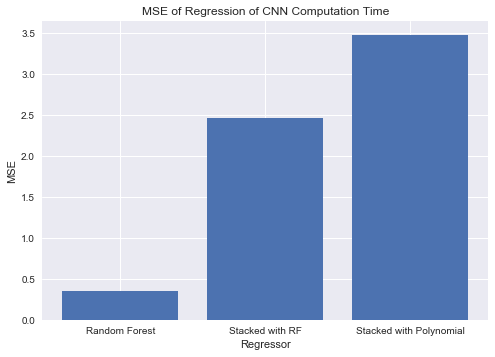

In [129]:
cnn_ms = [cnn_ms_rf_mse, cnn_ms_stacked_1_mse,cnn_ms_stacked_2_mse]
plt.bar([i for i in range(len(cnn_ms))], cnn_ms, tick_label=[
    'Random Forest',
    'Stacked with RF',
    'Stacked with Polynomial',
])
plt.title('MSE of Regression of CNN Computation Time')
plt.ylabel('MSE')

plt.xlabel('Regressor')
plt.show()

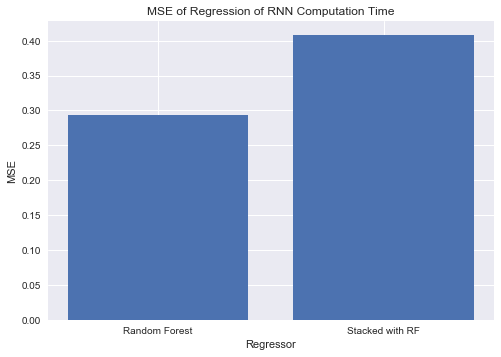

In [130]:
rnn_ms = [rnn_ms_rf_mse, rnn_ms_stacked_1_mse]#, rnn_ms_stacked_2_mse]

plt.bar([i for i in range(len(rnn_ms))], rnn_ms, tick_label=[
    'Random Forest',
    'Stacked with RF',
#     'Stacked with Polynomial',
])
plt.title('MSE of Regression of RNN Computation Time')
plt.ylabel('MSE')

plt.xlabel('Regressor')
plt.show()

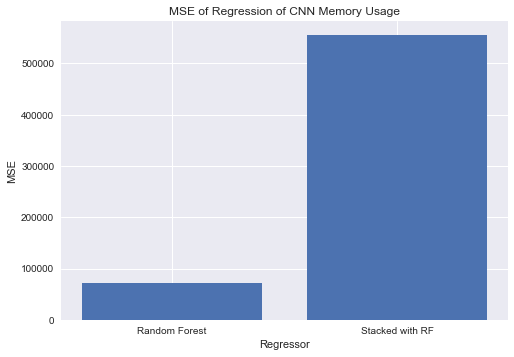

In [131]:
cnn_mem = [cnn_mem_rf_mse, cnn_mem_stacked_1_mse]
plt.bar(range(len(cnn_mem)), cnn_mem, tick_label=["Random Forest", "Stacked with RF"])

plt.title('MSE of Regression of CNN Memory Usage')
plt.ylabel('MSE')
plt.xlabel('Regressor')

plt.show()

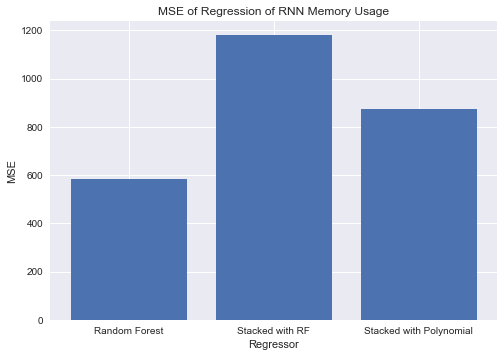

In [132]:
rnn_mem = [rnn_mem_rf_mse, rnn_mem_stacked_1_mse, rnn_mem_stacked_2_mse]

plt.bar(range(len(rnn_mem)), rnn_mem, tick_label=[
    "Random Forest",
    "Stacked with RF",
    "Stacked with Polynomial",
])

plt.title('MSE of Regression of RNN Memory Usage')
plt.ylabel('MSE')
plt.xlabel('Regressor')

plt.show()

In [137]:
def predict_cnn_ms(model):
    
    layer_features = get_layer_features(model)
    cleaned_features = clean(layer_features, inference=True)
    
    X = cleaned_features.drop(['name', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    
    predicted = cnn_ms_rf.predict(X)
    
    return predicted

def predict_cnn_mem(model):
    
    layer_features = get_layer_features(model)
    cleaned_features = clean(layer_features, inference=True)
    
    X = cleaned_features.drop(['name', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    
    predicted = cnn_mem_rf.predict(X)
    
    return predicted

def predict_rnn_ms(model):
    
    layer_features = get_layer_features(model)
    cleaned_features = clean(layer_features, inference=True)
    
    X = cleaned_features.drop(['name', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    
    predicted = rnn_ms_rf.predict(X)
    
    return predicted

def predict_rnn_mem(model):
    
    layer_features = get_layer_features(model)
    cleaned_features = clean(layer_features, inference=True)
    
    X = cleaned_features.drop(['name', 'input_shape', 'output_shape', 'strides'], axis=1)  # Features
    
    predicted = rnn_mem_rf.predict(X)
    
    return predicted
    



In [138]:
test_model = tf.keras.applications.resnet50.ResNet50(
    include_top=True,
    weights='imagenet')

predict_cnn_ms(test_model)

array([2.36353538e-01, 2.36353538e-01, 7.42407467e-01, 1.35628300e+00,
       4.46846130e+00, 1.35197900e+00, 1.74586864e+00, 5.04323484e-01,
       2.55629047e-01, 1.47515977e+00, 4.86585900e-01, 2.55629047e-01,
       1.47515977e+00, 1.20133403e+00, 1.20133403e+00, 1.35628300e+00,
       1.35628300e+00, 3.12488300e+00, 4.46846130e+00, 2.70438022e+00,
       2.55629047e-01, 1.47515977e+00, 4.86585900e-01, 2.55629047e-01,
       1.47515977e+00, 1.20133403e+00, 1.35628300e+00, 3.12488300e+00,
       4.46846130e+00, 2.70438022e+00, 2.55629047e-01, 1.47515977e+00,
       4.86585900e-01, 2.55629047e-01, 1.47515977e+00, 1.20133403e+00,
       1.35628300e+00, 3.12488300e+00, 4.46846130e+00, 2.86571840e+00,
       6.65594775e-02, 1.42459369e+00, 8.60290160e-02, 6.65594775e-02,
       1.42459369e+00, 7.10492832e+00, 1.14343720e+01, 1.89940684e-01,
       1.89940684e-01, 1.16728879e+00, 1.24703656e+00, 2.60023692e-01,
       6.65594775e-02, 1.42459369e+00, 8.60290160e-02, 6.65594775e-02,
      

In [139]:
predict_cnn_mem(test_model)

array([4.58366976e+02, 4.58366976e+02, 5.07565568e+02, 4.30150784e+02,
       2.86710982e+03, 4.28269184e+02, 1.13164730e+03, 8.55955904e+02,
       8.89117568e+02, 1.67417798e+03, 8.56031936e+02, 8.89117568e+02,
       1.67417798e+03, 3.68758656e+02, 3.68758656e+02, 4.30150784e+02,
       4.30150784e+02, 8.79883008e+02, 2.86710982e+03, 1.03390592e+03,
       8.89117568e+02, 1.67417798e+03, 8.56031936e+02, 8.89117568e+02,
       1.67417798e+03, 3.68758656e+02, 4.30150784e+02, 8.79883008e+02,
       2.86710982e+03, 1.03390592e+03, 8.89117568e+02, 1.67417798e+03,
       8.56031936e+02, 8.89117568e+02, 1.67417798e+03, 3.68758656e+02,
       4.30150784e+02, 8.79883008e+02, 2.86710982e+03, 5.25025984e+02,
       8.81678080e+01, 4.38814720e+02, 7.32794880e+01, 8.81678080e+01,
       4.38814720e+02, 5.93681408e+02, 9.47827456e+02, 5.74959680e+02,
       5.74959680e+02, 6.31324800e+02, 1.76282426e+03, 1.91770176e+02,
       8.81678080e+01, 4.38814720e+02, 7.32794880e+01, 8.81678080e+01,
      

In [140]:
from tensorflow.compat.v1.keras.models import Sequential
# from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

max_features = 20000
maxlen = 100
batch_size = 32

rnn_model = Sequential()
rnn_model.add(layers.Embedding(max_features, 128, input_length=maxlen))
rnn_model.add(layers.Bidirectional(layers.LSTM(64)))
rnn_model.add(layers.Dropout(0.5))
rnn_model.add(layers.Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
rnn_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

predict_rnn_ms(rnn_model)

# get_layer_features(rnn_model)


array([0.130042, 0.145918, 0.130042, 0.148489])

In [142]:
predict_rnn_mem(rnn_model)

array([24.705252, 29.568892, 24.705252, 24.705252])